# Credit Risk Analysis

## Table of Contents

* [Research & Data Exploration](#1)  
    * [Overview](#1.1)  
    * [Dataset Source](#1.2)  
    * [Project Related Literature Review](#1.3)  
    * [EDA - Exploratory Data Analysis](#1.4)  
        * [Load and Explore The Data](#1.4.1)  
        * [Class Distribution](#1.4.2)  
        * [Quantitative Variables](#1.4.3)  
        * [Categorical Variables](#1.4.4)  
* [Data Pre-Processing](#2)  
    * [Handling Missing Values](#2.1)  
    * [Handling Outliers](#2.2)  
    * [Encoding Categorical Variables](#2.3)  
    * [Feature Scaling](#2.4)  
    * [Training and Validation Sets](#2.5)  
* [Modelling / Classification](#3)  
    * [Logistic Regression Model](#3.1)  
        * [Building and Training The Model](#3.1.1)  
        * [Logistic Regression Model Evaluation](#3.1.2)  
        * [Recursive Feature Elimination to Improve Base Predictor](#3.1.3)
    * [Create and Evaluate Different Models](#3.2)  
        * [Building and Training The Models](#3.2.1)  
        * [Evaluating Models' Performance](#3.2.2)  
    * [Synthetic Minority Oversampling to Combat Class Imbalance](#3.3)  
        * [Base Predictor with Balanced Class Distribution](#3.3.1)
        * [Other Classifiers with Balanced Class Distribution](#3.3.2)
    * [GridSearchCV - Hyperparameter Tuning to Improve RandomForestClassifier](#3.4)
        

## Research & Data Exploration <a class="anchor" id="1"></a>

### Overview <a class="anchor" id="1.1"></a>

***Objective***: The data used in this project is related to simulating credit bureau data. The aim of the project is to build and train a binary classifier using the input features based on the individual characteristic of the applicant then evaluate the model on it's efficiency of predicting the individual's loan re-payment probability. (y) In other words, whether or not they will default on their re-payments. This information then can assist the decision making of loan companies whether to accept or refuse an application for a particular loan.

### Dataset Source <a class="anchor" id="1.2"></a>

_The Dataset used for this analysis is obtained from the Kaggle (https://www.kaggle.com/) website. Details about the dataset can be found here:_***https://www.kaggle.com/datasets/laotse/credit-risk-dataset/code***

Dataset was accessed on: **31/10/2022**

**Why was the dataset choosen?**

_Recently, Machine Learning algorithms have been increasingly applied for credit decision support to inform loan companies whether a loan for a particualar individual should be granted or refused based on the characteristics of the individual._ For this reason, this particualar dataset was choosen to build a sophisticated binary classifier that can efficiently contribute to this decision making.  
Furthermore, the data in this dataset consists of missing values, noise, outliers as well as both numerical and categorical variables which offer a chance to apply a variety of data pre-processing tools.

### Project Related Literature Review <a class="anchor" id="1.3"></a>

The selected article is focused on building and evaluating a binary classification model to aid credit decision support by leveraging data processing pipelines including methods for:
* _data re-sampling_ - random under- and oversampling, SMOTE 
* _feature discretization_ - transforming quantiative variables into discrete 'bins' with ordinal relationship 
* _feature selection_ -  wrapper, filter and ensemble methods

The primary focus of the research is to apply above techniques in one process when pre-processing the dataset. Balanced class distribution as the result of re-samplinh and the selection of relevant features for the model can reduce the computational burden as well as it can greatly improve the efficiency and understandability of the model.

The research was carried out with different scenarios based on applying above methods in different combinations. The research has concluded that the best predicitive accuracy was achieved using a _Random Forest_ classifier with applied Correlation-based Feature Selection. For this particular classifier Random Undersampling to manage class imbalance has provided a better classification result than discretization. Furthermore, the best overall result was also achieved with Random Forest on a full dataset with 272 features following dimensionality reduction to reduce feature space. 

The research however, was limited to evaluating model performance based on the accuracy of the classifier. This sometimes can be misleading and constraining depending on the preferences of the loan company - e.g.: they might care more about the accuracy of positive class predictions rather than all classes.

The project below uses binary classification with some of the processing techniques and classification models introduced in this such as Random Forest.

***Reference:***  
ZIEMBA P. et al., 2021. Credit Decision Support Based on Real Set of Cash Loans Using Integrated Machine Learning Algorithms. _Electronics_ 2021, 10(17), 2099.


### Exploratory Data Analysis <a class="anchor" id="1.4"></a>

#### <a class="anchor" id="1.4.1"></a><font color='green'>Load and Explore the Data</font>

In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE

In [2]:
# Use Pandas' .read_csv() function to load the dataset into a Pandas DataFrame and store it in a variable
credit = pd.read_csv('credit_risk_dataset.csv')

In [3]:
# Print the number of rows and columns in the DataFrame
print(f'The dataset contains: {credit.shape[0]} observations and {credit.shape[1]} features.')

The dataset contains: 32581 observations and 12 features.


In [4]:
# Save the features into a variable called 'columns' for easy access later on
columns = credit.columns
# Inspect features
columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

In [5]:
# Number of unique values present in each column
def get_unique_values(columns):
    for i in columns:
        print(i, '\t', len(credit[i].unique()))

get_unique_values(columns)

person_age 	 58
person_income 	 4295
person_home_ownership 	 4
person_emp_length 	 37
loan_intent 	 6
loan_grade 	 7
loan_amnt 	 753
loan_int_rate 	 349
loan_status 	 2
loan_percent_income 	 77
cb_person_default_on_file 	 2
cb_person_cred_hist_length 	 29


In [6]:
# Inspect the first five rows of the dataset
credit.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


<font color='green'>Checking the number of unique values in each column, as well as inspecting the first few rows of the DataFrame can give an initial feel to what kind of data is present in the dataset and how the data is structured. It can be assumed that the credit data contains both numerical and categorical variables</font>

In [7]:
# Inspect data types and check for missing values in the dataset
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


<div class='alert alert-block alert-info'><u>Note:</u> Data types suggest a mixture of numeric and categorical features are present in the dataset!</div>

<div class='alert alert-block alert-info'><u>Note:</u> Varying column lengths suggest missing data is present in some of the columns!</div>

<font color='green'>The **.info()** function proves the initial assumption about the data types (***numerical*** - int and float, ***categorical*** - object (string)). Furthermore, the count of Non-Null differ for some of the features which means there are missing values in the dataset</font>

In [8]:
# Ratio of missing values in the data set
# Save the % of missing values for each feature in a Pandas Series in a descending order
credit_missing = pd.Series(data=[round(credit[i].isnull().sum() / len(credit) * 100, 2) for i in columns], index=columns)
credit_missing.sort_values(ascending=False)

loan_int_rate                 9.56
person_emp_length             2.75
person_age                    0.00
person_income                 0.00
person_home_ownership         0.00
loan_intent                   0.00
loan_grade                    0.00
loan_amnt                     0.00
loan_status                   0.00
loan_percent_income           0.00
cb_person_default_on_file     0.00
cb_person_cred_hist_length    0.00
dtype: float64

<font color='green'> **Columns: 'loan_int_rate' and 'person_emp_length' contain missing values**. The proportion of missing values is relatively small in the employment length variable and slightly higher for the interest rate. Missing values will be handled at the _pre-processing stage_ before fitting the data to any Machine Learning model

### <a class="anchor" id="1.4.2"></a><font color='green'>Class Distribution</font>

The target feature in the dataset that we are trying to predict: **loan_status**
The status of the loan is represented as a binary variable where:
> * **0** (False) &rarr; **Non-Default** (Loan re-payment successful)
> * **1** (True) &rarr; **Default** (Loan re-payment failed)

In [9]:
# Create a copy of the dataset for visualization
credit_copy = credit.copy()

# Change the values of the target variable to allow easier interpretation
credit_copy['loan_status'] = credit_copy['loan_status'].apply(lambda x: 'Default' if x == 1 else 'Non-Default')

<font color='green'>The data type of the target feature by default is ***int (1 or 0)***, to provide a better interpretation when exploring class distribution, ***values are transformed to String values (Default or Non-Default)*** using a lambda function</font>

In [10]:
credit_copy['loan_status'].describe()

count           32581
unique              2
top       Non-Default
freq            25473
Name: loan_status, dtype: object

In [11]:
# Output the value counts for the target feature
credit_copy['loan_status'].value_counts()

Non-Default    25473
Default         7108
Name: loan_status, dtype: int64

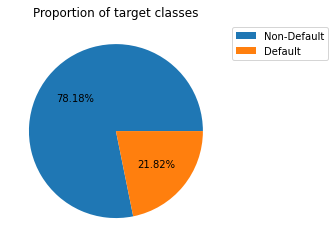

In [12]:
# Visualize class distribution proportions on a pie chart
def pie_visualize_distribution(target_feature, title):
    labels = credit_copy[target_feature].value_counts().index.tolist() # Extract the labels for plot legend
    
    # Create the pie chart with proprtion of values shown on chart
    plt.pie(credit_copy[target_feature].value_counts(), autopct=lambda x: f'{round(x, 2)}%')
    plt.title(title) # Set the tile for the plot
    # Create a legend with labels in the upper right corner
    plt.legend(labels, bbox_to_anchor=(1.5, 1), loc='upper right')
    plt.show() # Output the chart

pie_visualize_distribution('loan_status', 'Proportion of target classes')

<div class='alert alert-block alert-info'> <u>Note:</u> The proportion for target variable classes suggests a mildly imbalanced dataset!</div>

<font color='green'>The chart shows an **unequal distribution** among target classes. Training a Machine Learning model with imbalanced data can lead to the model being **biased** towards the negative class, and perform worse </font>

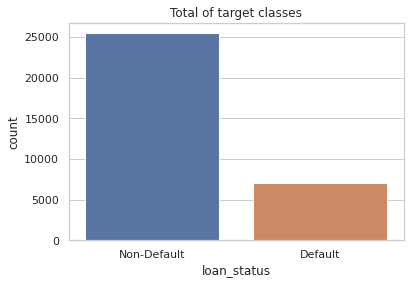

In [13]:
# Visualize total number for each class on a count plot
def count_visualize_distribution(target_feature, title):
    sns.set_theme(style='whitegrid')
    # Create the countplot for the target feature in the DataFrame
    sns.countplot(credit_copy, x=credit_copy[target_feature], 
                  order=credit_copy[target_feature].value_counts().index.tolist())
    plt.title(title) # Set the title for the plot
    plt.show() # Output the chart

count_visualize_distribution('loan_status', 'Total of target classes')

<font color='green'>The chart above shows the same unequality in class distribution but also shows the number of times each class appears in the dataset</font>

In [14]:
credit.groupby('loan_status').mean()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
loan_status,,,,,,,
0,27.807129,70804.361559,4.968745,9237.464178,10.435999,0.148805,5.837475
1,27.474676,49125.652223,4.137562,10850.502954,13.060207,0.246889,5.685003


<font color='green'>People who have a lower income (person_income), their loan amount would take a higer proportion of said income (loan_percent_income) are more likely to fail their loan re-payments. This would also suggest a **high correlation** between these variables</font>

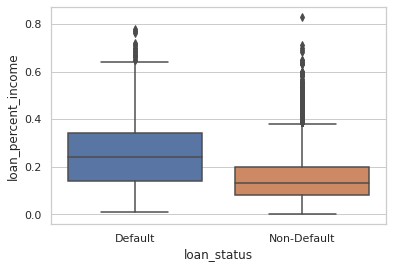

In [15]:
# Visualize the distribution of target classes based on the 'loan_percent_income' variable
def visualize_based_on(target_feature, based_on):
    sns.boxplot(credit_copy, x=credit_copy[target_feature], y=credit_copy[based_on])
    # plt.xlabel('Loan Status')
    # plt.ylabel('Loan % Income')
    plt.show()

visualize_based_on('loan_status', 'loan_percent_income')
# Note: Function allows for visualizing the distribution of target classes based on other predictor variable by
# by changing the 'based_on' parameter

<div class='alert alert-block alert-info'> <u>Note:</u> Boxplot detected outliers in the dataset!</div>

<font color='green'>The boxplot confirms the assumption made in the previous cell. Also some **outliers** are shown on the boxplot. These will be handled in the pre-processing stage</font>

### <a class="anchor" id="1.4.3"></a><font color='green'>Quantitative Variables</font>

In [16]:
# Select quantitative features only and save the column names into a variable 
credit_num_cols = credit.select_dtypes(include=['number']).columns
credit_num_cols

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_cred_hist_length'],
      dtype='object')

In [17]:
# Check the proportion of quantitative features in the dataset
round(len(credit_num_cols) / len(credit.columns) * 100, 1)

66.7

<font color='green'>2/3 of the variables in the dataset are **numerical**</font>

In [18]:
# Display summary statistics for the Quantitative variables in the DataFrame using .describe()
credit.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


<div class='alert alert-block alert-info'> <u>Note:</u> Potential outliers for the age, income and employment length columns, which will be further investigated and dealt with if necessary at the pre-processing stage</div>

<font color='green'>The **difference between the 75% quantile and the max value** for some variables suggest the presence of **outliers**</font>

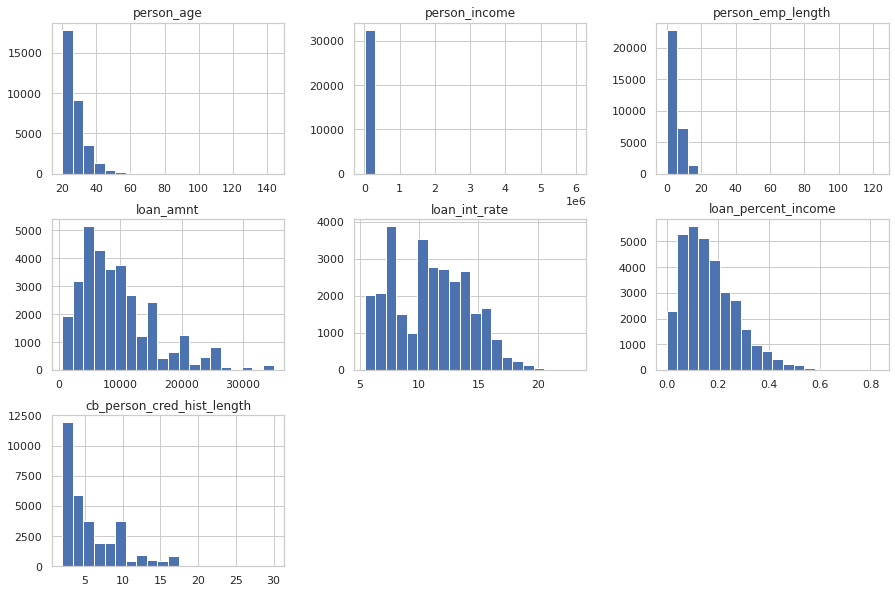

In [19]:
# Visualize numerical features on a histogram
credit[list(filter(lambda x: x != 'loan_status', credit_num_cols))].hist(bins=20, figsize=(15, 10))
plt.show()

<div class='alert alert-block alert-info'> <u>Note:</u> Features vary in scales that could affect the performance of the model, as well as most of their distribution is right-skewed</div>

<font color='green'>As noted above, most of the variables' distributions are **right-skewed** and on **different scales**. To handle this issue, **features will be scaled** at pre-processing</font>

In [20]:
# Generate correlation (Pearson's) matrix to gain more insight into the relationship between quantitative variables
# in the dataset 
corr_matrix = credit.corr()
corr_matrix

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
person_age,1.000000,0.173202,0.163106,0.050787,0.012580,-0.021629,-0.042411,0.859133
person_income,0.173202,1.000000,0.134268,0.266820,0.000792,-0.144449,-0.254471,0.117987
person_emp_length,0.163106,0.134268,1.000000,0.113082,-0.056405,-0.082489,-0.054111,0.144699
loan_amnt,0.050787,0.266820,0.113082,1.000000,0.146813,0.105376,0.572612,0.041967
loan_int_rate,0.012580,0.000792,-0.056405,0.146813,1.000000,0.335133,0.120314,0.016696
loan_status,-0.021629,-0.144449,-0.082489,0.105376,0.335133,1.000000,0.379366,-0.015529
loan_percent_income,-0.042411,-0.254471,-0.054111,0.572612,0.120314,0.379366,1.000000,-0.031690
cb_person_cred_hist_length,0.859133,0.117987,0.144699,0.041967,0.016696,-0.015529,-0.031690,1.000000


In [21]:
# Inspect how the target variable correlates with other quantitative features in the dataset
corr_matrix['loan_status'].abs().sort_values(ascending=False)[1:]

loan_percent_income           0.379366
loan_int_rate                 0.335133
person_income                 0.144449
loan_amnt                     0.105376
person_emp_length             0.082489
person_age                    0.021629
cb_person_cred_hist_length    0.015529
Name: loan_status, dtype: float64

<font color='green'>The highest correlation with the target feature is among how the **loan amount compares to the person's income** as well as the **interest rate**</font>

[]

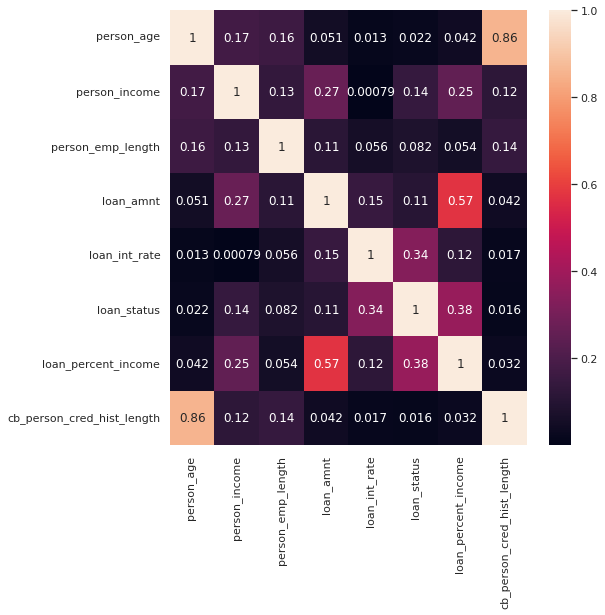

In [22]:
# Visualize the correlation matrix on a heatmap for better and easier interpretation of the relationships between
# each and every variable
ax = plt.figure(figsize=(8, 8))
ax = sns.heatmap(corr_matrix.abs(), annot=True)
plt.plot()

<font color='green'>There are notable correlation between other quantiative variables:</font>
* credit history length and person's age - strong positive correlation (0.86) (older the person is the longer their credit history
* loan amount compared to income and loan amount - positive correlation (0.57) (the higher the loan amount, the larger proportion it will be of the person's income

### <a class="anchor" id="1.4.4"></a><font color='green'>Categorical Variables</font>

In [23]:
# Select only categorical variables from the DataFrame
credit_cat = credit.select_dtypes(include=['object'])
credit_cat.head()

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
0,RENT,PERSONAL,D,Y
1,OWN,EDUCATION,B,N
2,MORTGAGE,MEDICAL,C,N
3,RENT,MEDICAL,C,N
4,RENT,MEDICAL,C,Y


In [24]:
# Get summary statistics for the categorical features representing (count, number of unique values, the mode and
# the frequency of the most common element)
credit_cat.describe()

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
count,32581,32581,32581,32581
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,16446,6453,10777,26836


<font color='green'>The values of categorical variables are not too diverese (most 7 - loan_grade), people most frequently **Rent** their property, while their purpose for loan is **Education** with a loan grade of **A**</font>

In [25]:
# Save the column names for categorical features into a variable
credit_cat_cols = credit_cat.columns
credit_cat_cols

Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object')

In [26]:
# Poroportion of categorical columns in the data set
round(len(credit_cat_cols) / len(credit.columns) * 100, 1)

33.3

<font color='green'>1 / 3 of the variables in the dataset are **categorical**<font>

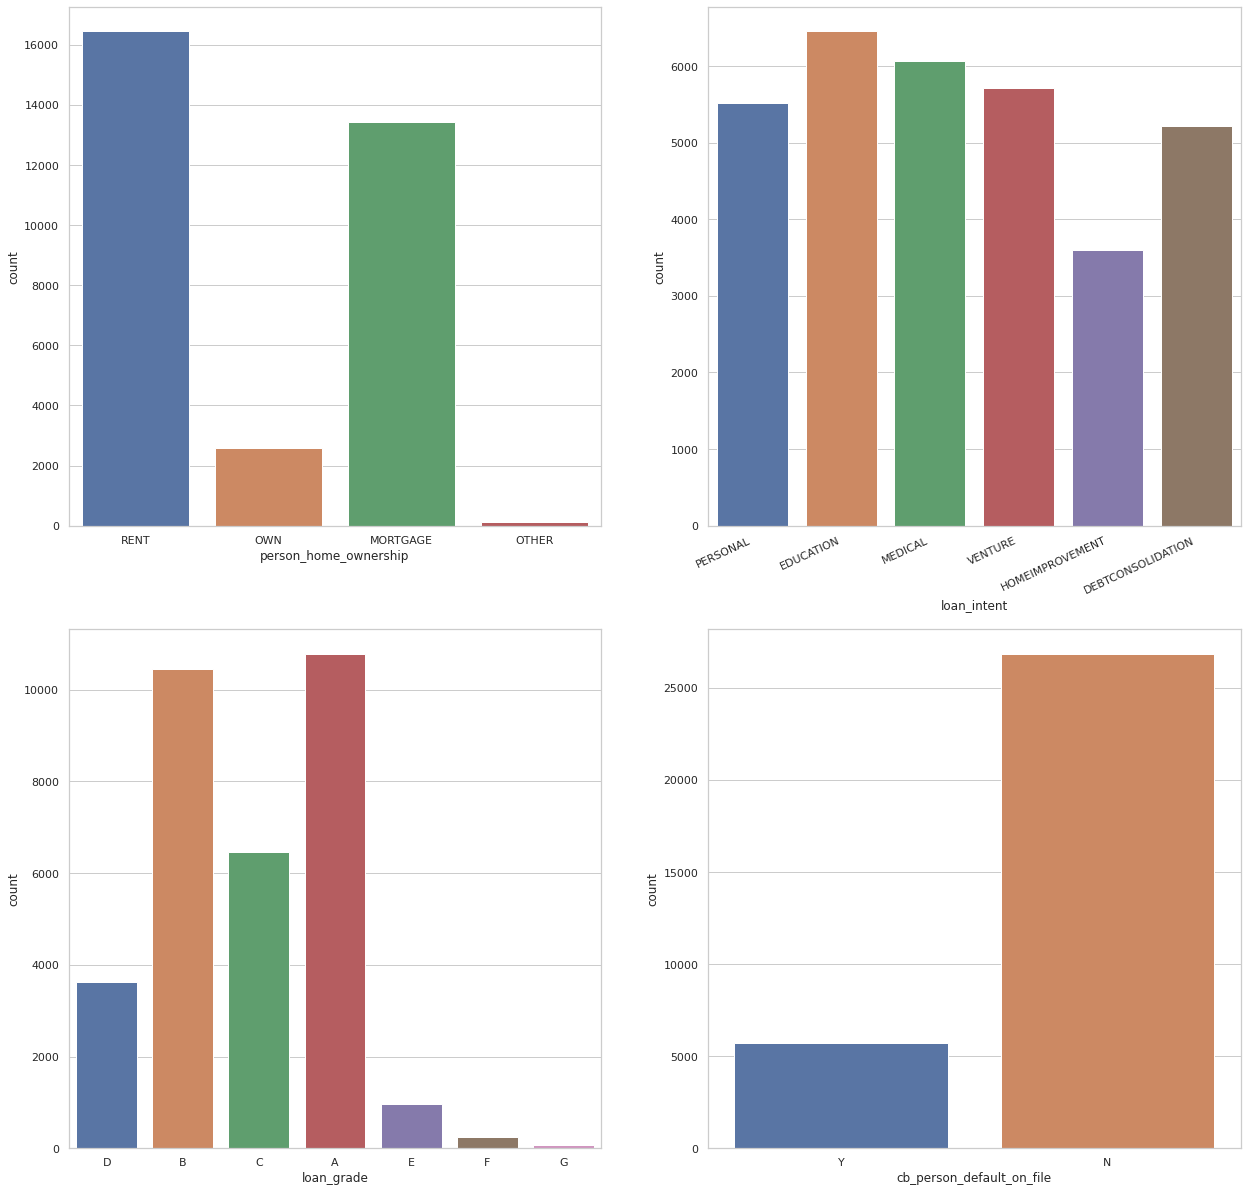

In [27]:
# Visualize the proportion of values for each categorical feature
def count_visualize_categorical(cat_cols, hue=None):
    plt.figure(figsize=(21, 21))
    # plt.tight_layout()
    for i in range(len(cat_cols)):
        ax = plt.subplot(2, 2, i + 1)
        ax = sns.countplot(data=credit_cat, x=credit_cat[cat_cols[i]], hue=hue)
        # To avoid overlapping labels for loan intent rotate labels to the right:
        if cat_cols[i] == 'loan_intent':
            ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right')
            
count_visualize_categorical(credit_cat_cols)

<font color='green'>Distribution of categorical variables in the dataset:</font>
* Home ownership - people tend to rent their property or have a mortgage on it
* Loan intent - well-balanced, home improvement tends to be the less common reason for loan
* Loan grade - Loan grade is imbalanced in this dataset - Loan A and B are the most common
* Default on file - Binary variable - imbalanced where negative class is in the majority

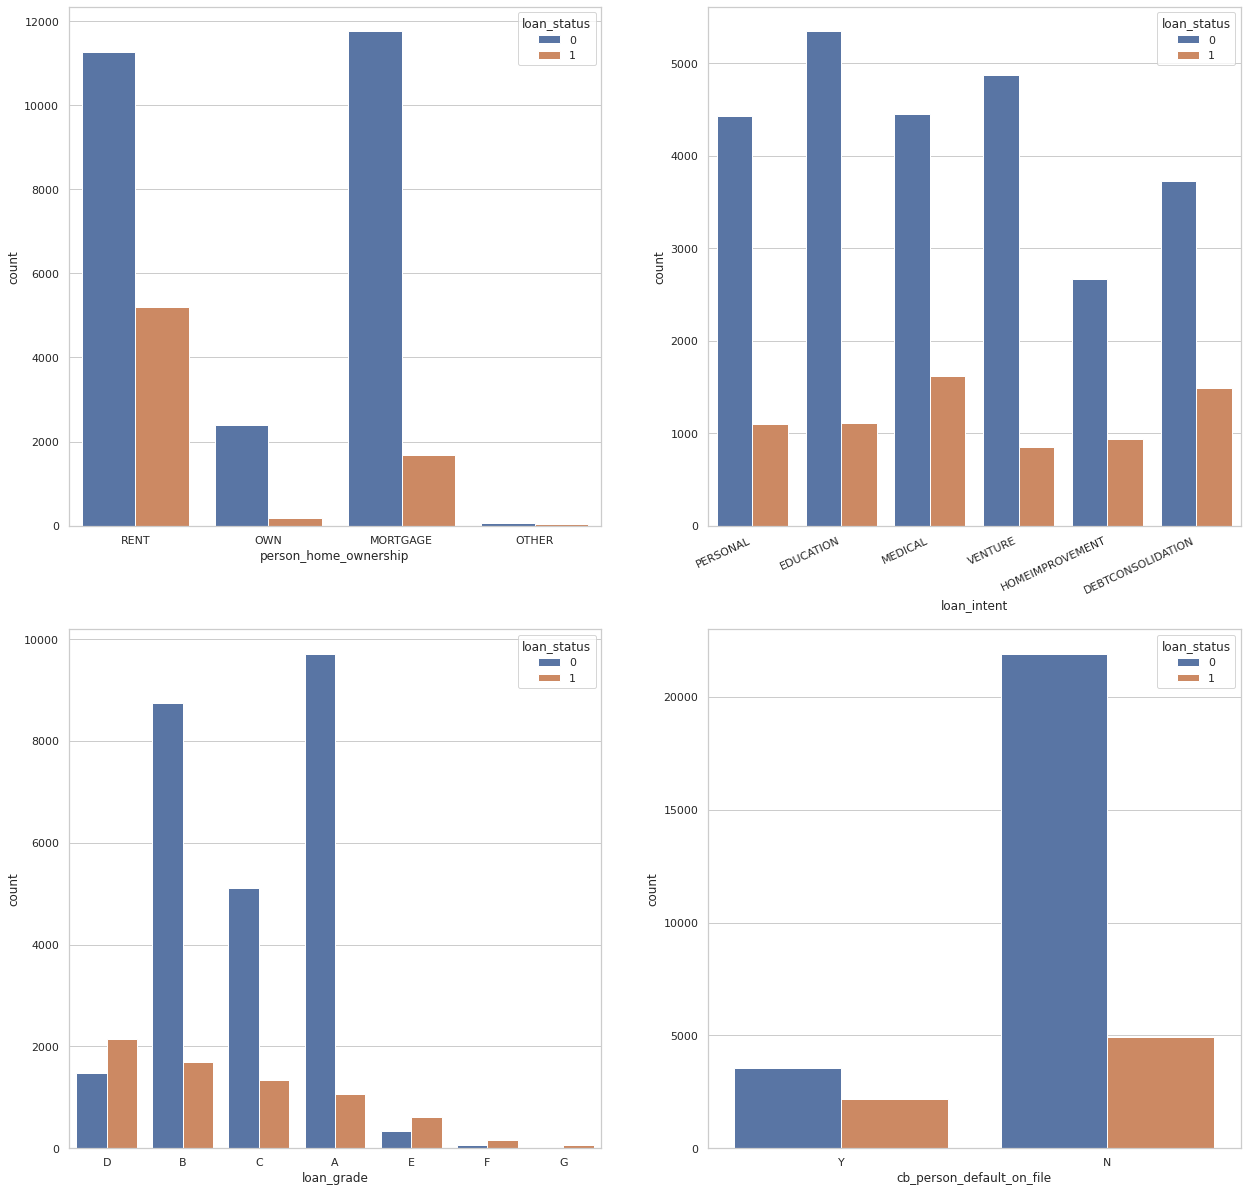

In [28]:
# Visualize the proportion of categorical values in terms of the target variable
"""plt.figure(figsize=(21, 21))
# plt.tight_layout()
for i in range(len(credit_cat_cols)):
    ax = plt.subplot(2, 2, i + 1)
    ax = sns.countplot(data=credit_cat, x=credit_cat[credit_cat_cols[i]], hue=credit['loan_status'])
    # To avoid overlapping labels for loan intent rotate labels to the right:
    if credit_cat_cols[i] == 'loan_intent':
        ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right')"""

# Call the visualize function and pass in the loan status as the parameter to do the counting
count_visualize_categorical(credit_cat_cols, credit['loan_status'])

<font color='green'>Key things to note about the distribution of categorical variables based on the target feature:</font>
* People who fail their re-payments tend to rent their property 
* They usually belong to a loan grade D - within this grade and the following grades (E,F,G) they tend to be in majority compared to people who are in the negative class

### Data Pre-processing <a class="anchor" id="2"></a>

### <a class="anchor" id="2.1"></a><font color='green'>Handling Missing Values</font>

In [29]:
# Output the number of missing values where applicable along with the percentage of missing values compared to the 
# total number of values for the feature
credit_missing_cols = []  # Create a list to store columns with missing values
for col in columns:
    if (credit[col].isnull().sum() > 0):
        credit_missing_cols.append(col)  # Add the column name to the list
        print(f'Column name: {col}\nNumber of missing values: {credit[col].isnull().sum()}\nPercentage of missing values: {credit[col].isnull().sum() / len(credit) * 100}%\n')

Column name: person_emp_length
Number of missing values: 895
Percentage of missing values: 2.7469997851508547%

Column name: loan_int_rate
Number of missing values: 3116
Percentage of missing values: 9.563856235229121%



In [30]:
print(f'Columns with missing values: {credit_missing_cols}')

Columns with missing values: ['person_emp_length', 'loan_int_rate']


In [31]:
corr_matrix

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
person_age,1.000000,0.173202,0.163106,0.050787,0.012580,-0.021629,-0.042411,0.859133
person_income,0.173202,1.000000,0.134268,0.266820,0.000792,-0.144449,-0.254471,0.117987
person_emp_length,0.163106,0.134268,1.000000,0.113082,-0.056405,-0.082489,-0.054111,0.144699
loan_amnt,0.050787,0.266820,0.113082,1.000000,0.146813,0.105376,0.572612,0.041967
loan_int_rate,0.012580,0.000792,-0.056405,0.146813,1.000000,0.335133,0.120314,0.016696
loan_status,-0.021629,-0.144449,-0.082489,0.105376,0.335133,1.000000,0.379366,-0.015529
loan_percent_income,-0.042411,-0.254471,-0.054111,0.572612,0.120314,0.379366,1.000000,-0.031690
cb_person_cred_hist_length,0.859133,0.117987,0.144699,0.041967,0.016696,-0.015529,-0.031690,1.000000


In [32]:
# Check how the features correlate with the target feature
corr_matrix['loan_status'].loc[['person_emp_length', 'loan_int_rate']]

person_emp_length   -0.082489
loan_int_rate        0.335133
Name: loan_status, dtype: float64

In [33]:
# Remove observations with missing employment length using the .dropna() function
credit.dropna(subset=['person_emp_length'], inplace=True)

<font color='green'>There was almost no correlation found between the length of employment and the target variable. Missing values in this variable contribute to 2.75% of total values, hence rows with missing values in the employment length column can be removed from the data set</font>

In [34]:
credit.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length                0
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3048
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [35]:
# The number of missing values for the employment length feature now is 0. As well the number of missing values for
# the interest rate has also decreased, meaning that there were observations who were missing both value.
# The interest rate feature is somewhat correlated with the target feature, however there are no apparent correlation
# between interest rate and other features, which means interest rate is specified using extraneous circumstances
# that are outside the scope of the dataset. Hence missing values for this feature will be filled with the most
# frequent value in the variable

# ! pip install scikit-learn
# from sklearn.impute import SimpleImputer

# Instantiate the SimpleImputer object
imp_most_frequent = SimpleImputer(strategy='most_frequent')

# Fit and transform the loan_int_rate variable
credit['loan_int_rate'] = imp_most_frequent.fit_transform(credit['loan_int_rate'].values.reshape(-1, 1))


<font color='green'>The interest rate is somewhat correlated (0.335) with the target variable, but does not correlate to other features. This could be due to interest rates being set based on extraneous circumstances, hence to avoid having to drop observations, missing values for this column are filled in with the mode of the column using a SimpleImputer</font>

In [36]:
# Check if any missing values still remain in the dataset
credit.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

<font color='green'>***All missing values in the dataset have been handled!***</font>

### <a class="anchor" id="2.2"></a><font color='green'>Handling Outliers</font>

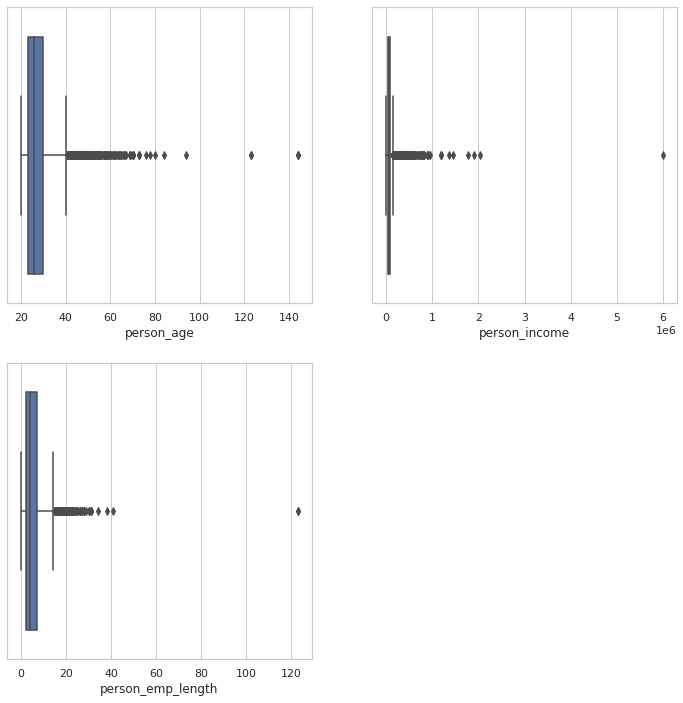

In [37]:
# To enhance the accuracy of the predictive model, outliers in the dataset must be handled first
# Visualize the three input features with potential outliers
cols = ['person_age', 'person_income', 'person_emp_length']

def visualize_outliers(cols):
    fig = plt.figure(figsize=(12, 12))
    for i in range(0, len(cols)):
        ax = fig.add_subplot(2, 2, i+1)
        ax = sns.boxplot(x=credit[cols[i]])

visualize_outliers(cols)

<font color='green'>The boxplots above show that all three columns have some large outliers which could be the result of a mistake when inputting data, such as person age >140 years</font>

In [38]:
def cal_upper_limit(feature):
    # Method to calculate the maximum values at the whiskers (Q3 + (1.5 * IQR))
    IQR = credit[feature].quantile(0.75) - credit[feature].quantile(0.25) # Inter Quantile Range
    return credit[feature].quantile(0.75) + (1.5 * IQR)

# Calculate the upper limit for all columns
limit_dict = {col:cal_upper_limit(col) for col in cols}

# Remove values from the dataset that are above the upper limit
for col, limit in limit_dict.items():
    credit = credit[(credit[col] < limit)]

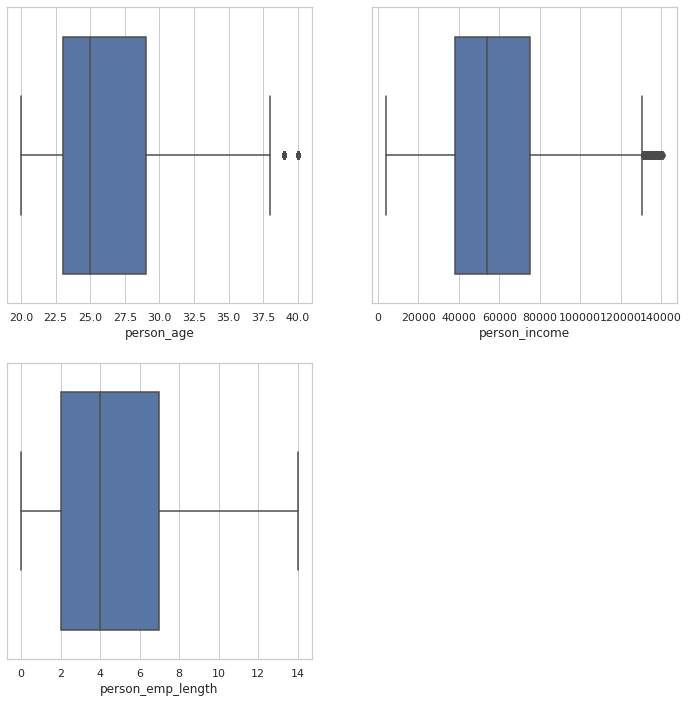

In [39]:
"""fig = plt.figure(figsize=(12, 12))
for i in range(0, len(cols)):
    ax = fig.add_subplot(2, 2, i+1)
    ax = sns.boxplot(x=credit[cols[i]])"""
# Create the boxplots after removing the outliers
visualize_outliers(cols)

<font color='green'>***Outliers for these columns are handled by dropping values located outside the upper whisker of the boxplot. This results in more maintanable and less noisy data in these columns.***</font>

### <a class="anchor" id="2.3"></a><font color='green'>Encoding Categorical Variables</font>

In [40]:
# The 'cb_person_default_on_file' feature values are already in binary True or False represented as Y or N
# Using the .replace() function, string values can be converted into integers (1 or 0)
credit['cb_person_default_on_file'].replace(['Y', 'N'], [1, 0], inplace=True)

<font color='green'>**Default on file**: This is a binary variable, hence 'Y' and 'N' values can be updated to corresponding 1s and 0s using Pandas' .replace() method</font>

In [41]:
# 1/3 of the features in the dataset are categorical hence these must be transformed into integers prior fitting the
# data on the model
# It can be assumed that the loan_grade feature is ordinal, meaning that the categorical values have an order and
# range from best to worst (from A to G).
# OrdinalEncoder from the Scikit-Learn library can be used to encode this feature while also maintaining the order of
# it's values
# from sklearn.preprocessing import OrdinalEncoder

# Instantiate the encoder, passing in the category values
ordinal_encoder = OrdinalEncoder(categories=[['A', 'B', 'C', 'D', 'E', 'F', 'G']])

loan_grade_reshaped = credit['loan_grade'].values.reshape(-1, 1)  # reshape the feature into a 2-D np array

# Fit the array to the scaler and transform the feature in the DataFrame
credit['loan_grade'] = ordinal_encoder.fit_transform(loan_grade_reshaped)


<font color='green'>**Loan grade**: Assuming that the values in this column follow an order, using OrdinalEncoder from the sklearn preprocessing module, values are transformed to numerical while maintaining the order.  

Once the loan grade feature is type numeric, examine how it correlates with other features in the dataset:</font>

In [42]:
credit.corr()['loan_grade'].sort_values(ascending=False)[1:]

loan_int_rate                 0.889008
cb_person_default_on_file     0.536415
loan_status                   0.375695
loan_amnt                     0.136557
loan_percent_income           0.130682
cb_person_cred_hist_length    0.013496
person_age                    0.012814
person_income                -0.037866
person_emp_length            -0.056826
Name: loan_grade, dtype: float64

<font color='green'>There is a strong positive correlation with the interest rate, meaning that the higher the interest rate, the worse the loan grade it (assuming that grade A is the best). Similarly, the worse the grade is, higher the chance that the applicant has gone default before. There is also a mild positive correlation between the loan grade and the target feature</font>

In [43]:
# For handling the rest of the categorical features, One-Hot-Encoding (OHE) is used to create a dummy variable 
# for each values in the variable
# OHE can be argued as not space efficient, if there are features with a wide variety of values, BinaryEncoder 
# could be used to reduce the sparse matrix, by converting each category to its binary representation

# Using the Pandas' .get_dummies() function to create dummy variables
ohe = pd.get_dummies(credit[['person_home_ownership', 'loan_intent']])

credit = pd.concat([credit, ohe], axis=1)  # Concatenate the dummy DataFrame with the original DataFrame

# Drop the original categorical columns
credit.drop(columns=['person_home_ownership', 'loan_intent'], inplace=True)

<font color='green'>**Home ownership** and **Loan intent**: These variables can be encoded using OHE. OHE essentially is not efficient in terms of space, however in case of this dataset, the number of unique values in these columns are relatively small</font>

In [44]:
# Visualize the new credit DataFrame
credit.head()

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
1,21,9600,5.0,1.0,1000,11.14,0,0.10,0,2,0,0,1,0,0,1,0,0,0,0
2,25,9600,1.0,2.0,5500,12.87,1,0.57,0,3,1,0,0,0,0,0,0,1,0,0
3,23,65500,4.0,2.0,35000,15.23,1,0.53,0,2,0,0,0,1,0,0,0,1,0,0
4,24,54400,8.0,2.0,35000,14.27,1,0.55,1,4,0,0,0,1,0,0,0,1,0,0
5,21,9900,2.0,0.0,2500,7.14,1,0.25,0,2,0,0,1,0,0,0,0,0,0,1


In [45]:
# Call .info() to check the updated dtypes
credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28259 entries, 1 to 32296
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      28259 non-null  int64  
 1   person_income                   28259 non-null  int64  
 2   person_emp_length               28259 non-null  float64
 3   loan_grade                      28259 non-null  float64
 4   loan_amnt                       28259 non-null  int64  
 5   loan_int_rate                   28259 non-null  float64
 6   loan_status                     28259 non-null  int64  
 7   loan_percent_income             28259 non-null  float64
 8   cb_person_default_on_file       28259 non-null  int64  
 9   cb_person_cred_hist_length      28259 non-null  int64  
 10  person_home_ownership_MORTGAGE  28259 non-null  uint8  
 11  person_home_ownership_OTHER     28259 non-null  uint8  
 12  person_home_ownership_OWN       

<font color='green'>***All variables in the dataset are of numerical type!***</font>

### <a class="anchor" id="2.4"></a><font color='green'>Feature Scaling</font>

In [46]:
# As it was shown above, numerical feature values are on different scales as well as they do not follow normal
# distribution. 
# To attend this issue, data will be normalized using a MinMaxScaler() to scale values between 0 and 1
# from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()  # Create a new scaler object
# Select features to scale - loan_status is the target variable, loan_percent_income is already on scale
num_cols_to_scale = [col for col in credit_num_cols if col not in ['loan_status', 'loan_percent_income']]

credit[num_cols_to_scale] = scaler.fit_transform(credit[num_cols_to_scale])  # Fit the data to the scaler

credit[num_cols_to_scale].describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,cb_person_cred_hist_length
count,28259.000000,28259.000000,28259.000000,28259.000000,28259.000000,28259.000000
mean,0.327968,0.400369,0.312790,0.255701,0.315215,0.211494
std,0.219663,0.199800,0.242064,0.174576,0.171967,0.216640
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.150000,0.247917,0.142857,0.130435,0.172472,0.066667
50%,0.250000,0.364859,0.285714,0.217391,0.312921,0.133333
75%,0.450000,0.518345,0.500000,0.333333,0.434831,0.333333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<font color='green'>As it was identified during data exploration, numerical variables in the dataset are on a different scale. This problem can be handled using a MinMaxScaler which essentially scales all numerical features to the same range - in this case between 0 and 1 where 0 is the minimum value and 1 is the maximum for the given variable </font>

<font color='green'>***Following applying a MinMaxScaler, all all numerical features are on the same scale!***</font>

### <a class="anchor" id="2.5"></a><font color='green'>Training and Validation Sets</font>

In [47]:
# Save the input features into a variable (X)
X = credit.drop('loan_status', axis=1)

In [48]:
# Save the target variable into a variable (y)
y = credit['loan_status']

In [49]:
# Split the dataset into Training and Testing sets using the train_test_split() function from sklearn's
# model_selection library
# from sklearn.model_selection import train_test_split # import the module

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [50]:
# Check the class distribution in the training set after the split
y_train.value_counts(normalize=True)

0    0.776972
1    0.223028
Name: loan_status, dtype: float64

In [51]:
# Check the class distribution in the validation set after the split
y_test.value_counts(normalize=True)

0    0.780786
1    0.219214
Name: loan_status, dtype: float64

### Modelling / Classification <a class="anchor" id="3"></a>

_The aim of the project is to predict that an instance belongs to a particular class, and therefore it is a classification problem._ (Since the problem involves only two labels, it is a binary classification)

The first model that will be built and evaluated for this purpose is a **Logistic Regression Model**.

The Logistic Regression Model calculates the probability of an instance belonging to a particular class, by using the Euler number (base for natural logarithm) and the combination of weights and input features. 

### <a class="anchor" id="3.1"></a><font color='green'>Logistic Regression Model</font>

#### Building and Training the Model <a class="anchor" id="3.1.1"></a>

In [52]:
# Import the LogisticRegression class and instantiate the model
# from sklearn.linear_model import LogisticRegression

lg_model = LogisticRegression(class_weight='balanced')
# Set class_weight parameter to adjust class weights inversely proportional to class distribution

In [53]:
# Train the model using the Training set of features and labels
lg_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

#### Logistic Regression Model Evaluation <a class="anchor" id="3.1.2"></a>

In [54]:
# Create a Confusion Matrix to evaluate the accuracy of the model
# The Confusion Matrix returns a 2D array containing the results from comparing predicted values to the actual
# values representing True Negatives, False Positives, False Negatives and True Positives

y_pred = lg_model.predict(X_test)

confusion_matrix(y_pred=y_pred, y_true=y_test)

array([[3478,  935],
       [ 266,  973]])

<font color='green'>In terms of predicting instances with class label of 0, the model was fairly accurate, however in terms of positive classes almost half of the predictions were False Positive</font>

In [55]:
# Define a function to create a DataFrame consisting evaluation metrics
def evaluate_models(models, X_test, y_test):
    # Create an empty DataFrame
    evaluation_df = pd.DataFrame(columns=['Classifier', 'Accuracy', 'Recall', 'Precision', 'F1 Score', 'ROC AUC'])
    # Loop over models, calculate scores and add them to the DataFrame
    for model in models:
        model_values = []
        
        model_pred = model.predict(X_test)
        
        model_values.append(model.__class__.__name__)
        model_values.append(accuracy_score(y_test, model_pred))
        model_values.append(recall_score(y_test, model_pred))
        model_values.append(precision_score(y_test, model_pred))
        model_values.append(f1_score(y_test, model_pred))
        model_values.append(roc_auc_score(y_test, model_pred))
        
        evaluation_df.loc[len(evaluation_df.index)] = model_values
    
    return evaluation_df

lg_evaluation_df = evaluate_models([lg_model], X_test, y_test)
lg_evaluation_df

,Classifier,Accuracy,Recall,Precision,F1 Score,ROC AUC
0,LogisticRegression,0.787509,0.785311,0.509958,0.618367,0.786718


<font color='green'>Evaluation discussion:</font>
* **Accuracy** - the percentage of correctly classified predictions (TP + TN) out ot total predictions
    * The base predictor performs poorly - due to class imbalance the model is biased towards the negative class, hence positive classes often got misclassified &rarr; high false positive rate
* **Recall** - the ratio of positive classes correctly classified by the predictor (TP / (TP + FN))
    * The base predictor performs poorly on the recall score since many instances were misclassified as False Negative when in reality they belong to the positive class
* **Precision** - the accuracy of positive predictions - how well the model can predict positive classes (TP / (TP + FP))
    * The base predictor does extremly poorly - almost only every second positive classification is correct (very high ratio of False Positives)
* **F1** - the effectiveness or (harmonic mean) of the model - calculated using precision and recall (called harmonic since lower values have more weight, meaning the model's F1 score can only be high if both precision and recall values are high)
    * The base predictor is not effective due to the extremly low precision score
* **AUC** - measures how well the model can distinguish between classes
    * The base predictor has a low AUC score which could also be explained by the class imbalance, where the positive class is rare 
    
<font color='green'>The model does well predicting negative classes but very inaccurate predicting positive classes due to bias</font>

In [56]:
# The Receiver Operating Characteristic (ROC) curve of the model
# The ROC curve can be used to plot the TP rate of the model against the FP rate. 
# from sklearn.metrics import roc_curve

# Get the FP and TP rates for various threshold values
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

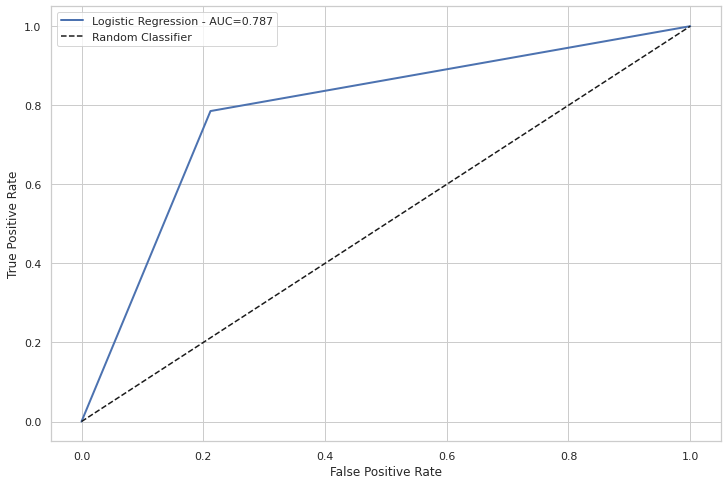

In [57]:
# Plot the ROC curve

fig = plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, linewidth=2, label=f'Logistic Regression - AUC={round(roc_auc_score(y_test, y_pred), 3)}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

<font color='green'>The plot above shows how the Logistic Regression model compares to a Random Classifier - which is basically predicting based on random guessing. AUC measures the Area Under the Curve and provides a way to compare classifiers, which as a baseline for the Random Classifier is 0.5, and for the Logistic Regression model is 0.787</font>

#### Recursive Feature Elimination to improve base predictor  <a class="anchor" id="3.1.3"></a>

***Recursive Feature Elimination*** is an iterative process where the model is trained on all available features then each of those features get ranked by their feature importance based on their value of coefficient. The least important feautre then gets removed. The process continues until the desired number of n_features is reached.

In [58]:
lg_model = LogisticRegression(class_weight='balanced', max_iter=500) # Create a new Logistic Regression model

rfe = RFE(lg_model) # Create the RFE instance

param_grid = {
    # Define values to validate in GridSearch for the RFE object
    'n_features_to_select': np.arange(2, len(X_train.columns))
}

# Create the GridSearchCV object and fit the data
# Using accuracy for the scoring metric
grid_rfe = GridSearchCV(rfe, param_grid=param_grid, cv=3, scoring='accuracy')
grid_rfe.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=RFE(estimator=LogisticRegression(class_weight='balanced',
                                                        max_iter=500)),
             param_grid={'n_features_to_select': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18])},
             scoring='accuracy')

In [59]:
# Get the best value for the number of features for RFE
grid_rfe.best_params_

{'n_features_to_select': 16}

In [60]:
# Test the accuracy of the best performing model following CV
grid_rfe.score(X_test, y_test)

0.7882165605095541

<font color='green'>Choosing 'n' number of features from the training set has improved the model accuracy slightly compared to training the model on all available features</font>

In [61]:
# See which n_features were selected by the best Recursive Feature Elimination estimator

feature_support = grid_rfe.best_estimator_.support_
# feature_support --> an array of True and False values whether the feature was choosen or not
# Use the column names from the training set and the binary array to check which features got selected by RFE
rfe_features = [f for (f, support) in zip(X_train.columns, feature_support) if support]
rfe_features

['person_age',
 'person_income',
 'loan_grade',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length',
 'person_home_ownership_MORTGAGE',
 'person_home_ownership_OTHER',
 'person_home_ownership_OWN',
 'person_home_ownership_RENT',
 'loan_intent_DEBTCONSOLIDATION',
 'loan_intent_EDUCATION',
 'loan_intent_HOMEIMPROVEMENT',
 'loan_intent_MEDICAL',
 'loan_intent_VENTURE']

### <a class="anchor" id="3.2"></a><font color='green'>Create and Evaluate Different Classifiers</font>

To improve the solution for this binary classification, in this section the data used to train the Logistic Regression model will be used to train several different kind of models. Then, the accuracy along with the predictive power of each model will be evaluated to find to find the most powerful classifier.

Models used:
> * KNN
> * DecisionTree
> * RandomForest

#### Building and Training the Models <a class="anchor" id="3.2.1"></a>

In [62]:
# Instantiate each classifier
classifiers = [
    KNeighborsClassifier(n_neighbors=3, weights='distance'),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(n_estimators=500, random_state=42)
]

In [63]:
# Function for training classifiers and making predictions
def train_and_predict(classifiers):
    models_and_predictions = {}
    for classifier in classifiers:
        model = classifier.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        models_and_predictions[model] = y_pred
    return models_and_predictions

models_and_predictions = train_and_predict(classifiers)

#### Evaluating Models' Performance <a class="anchor" id="3.2.2"></a>

In [64]:
# Create the Evaluation DF
models_evaluation_df = evaluate_models(classifiers, X_test, y_test)
models_evaluation_df

,Classifier,Accuracy,Recall,Precision,F1 Score,ROC AUC
0,KNeighborsClassifier,0.884643,0.611784,0.815931,0.699262,0.786517
1,DecisionTreeClassifier,0.891366,0.779661,0.739097,0.758837,0.851195
2,RandomForestClassifier,0.935775,0.728006,0.971983,0.832487,0.861057


<font color='green'>The **Random Forest Classifier** outperforms the other models in almost all evaluation metrics. Due to the class imbalance the sensitivity of the ensemble is poor, in this metrics a Decision Tree Classifier achieves the highest score. Random Forest has a ***97.19% accuracy of predicting positive instances*** while also over 93% overall accuracy</font>

In [65]:
# Get FP and TP rates as well as AUC score for each model
def get_roc_results(models_and_predictions):
    roc_results = pd.DataFrame(columns=['Classifier', 'fpr', 'tpr', 'auc'])
    for model, pred in models_and_predictions.items():
        fpr, tpr, thresholds = roc_curve(y_test, pred)
        auc = roc_auc_score(y_test, pred)
        roc_results = roc_results.append({
            'Classifier': model.__class__.__name__,
            'fpr': fpr,
            'tpr': tpr,
            'auc': auc
        }, ignore_index=True)
    roc_results.set_index('Classifier', inplace=True)
    return roc_results

roc_results = get_roc_results(models_and_predictions)
# roc_results

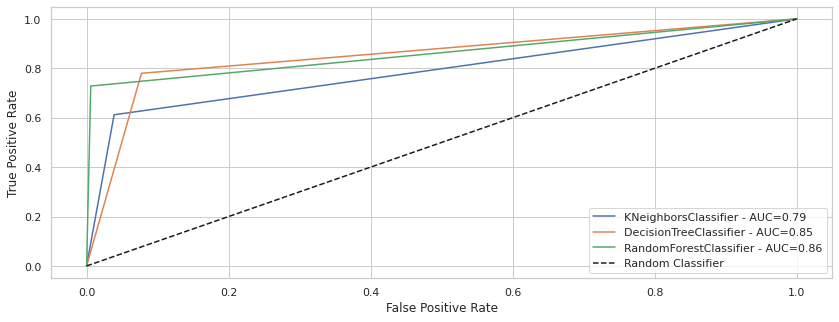

In [66]:
# Visualize the predictive power of each model on a ROC curve
def plot_roc_curve(roc_results):
    fig = plt.figure(figsize=(14, 5))
    for i in roc_results.index:
        auc = roc_results.loc[i]['auc']
        plt.plot(roc_results.loc[i]['fpr'], roc_results.loc[i]['tpr'],
                 label=f'{i} - AUC={round(auc, 2)}')
        
        # Plot the random classifier
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
        
        # Set plot variables
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

plot_roc_curve(roc_results)

<font color='green'>The above plot compares the Area Under the Curve Score for all three classifiers and measures them against a Random Classifier</font>

### <a class="anchor" id="3.2"></a><font color='green'>Synthetic Minority Oversampling to Combat Class Imbalance</font>

**SMOTE** oversampling works in such a way that it selects neighbors randomly from the _'k'_ nearest neighbors of the real point then one synthetic object gets generated based on the qualities of each of the neighbors.

Since SMOTE uses interpolation instead of copying the original point this can aid ***avoiding overfitting***. 

In [67]:
smote = SMOTE(random_state=42, k_neighbors=5)
X_oversample, y_oversample = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_oversample, y_oversample, test_size=0.2, random_state=42)

In [68]:
y_oversample.value_counts(normalize=True)

0    0.5
1    0.5
Name: loan_status, dtype: float64

<font color='green'>Following oversampling the target feature's values are equally distributed</font>

#### Base predictor with balanced class distribution <a class="anchor" id="3.3.1"></a>

In [69]:
# Instantiate and train the predictor
lg_balanced = LogisticRegression(class_weight='balanced', max_iter=3000)
lg_balanced.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=3000)

In [70]:
# Create the Evaluation DF for the base predictor
lg_balanced_evaluation_df = evaluate_models([lg_balanced], X_test, y_test)
lg_balanced_evaluation_df

,Classifier,Accuracy,Recall,Precision,F1 Score,ROC AUC
0,LogisticRegression,0.791401,0.788108,0.790285,0.789195,0.791372


<font color='green'>Following SMOTE, the base predictor's Accuracy, Recall and AUC score have remaind roughly the same, however, the accuracy of predicring positive classes (Precision) has increased significantly as expected, consequently with the increase of Precision the F1 Score has increased too. All in all, the Logistic Regression model still under performs when compared to other classifiers.</font>

#### Other classifiers with balanced class distribution<a class="anchor" id="3.3.2"></a>

In [71]:
# Train classifiers and make predictions
models_and_predictions = train_and_predict(classifiers)

In [72]:
# Evaluate the models and create the evaluation DF
models_balanced_evaluation_df = evaluate_models(classifiers, X_test, y_test)

models_balanced_evaluation_df

,Classifier,Accuracy,Recall,Precision,F1 Score,ROC AUC
0,KNeighborsClassifier,0.892175,0.961433,0.842995,0.898327,0.892799
1,DecisionTreeClassifier,0.890924,0.899908,0.882287,0.891010,0.891005
2,RandomForestClassifier,0.943244,0.907254,0.976526,0.940616,0.942919


In [73]:
# Output the Evaluation DF before SMOTE
models_evaluation_df

,Classifier,Accuracy,Recall,Precision,F1 Score,ROC AUC
0,KNeighborsClassifier,0.884643,0.611784,0.815931,0.699262,0.786517
1,DecisionTreeClassifier,0.891366,0.779661,0.739097,0.758837,0.851195
2,RandomForestClassifier,0.935775,0.728006,0.971983,0.832487,0.861057


<font color='green'>The oversampling of the target feature has resulted in a much higher evaluation scores across all models. The balanced class distribution has greatly increased the Recall scores, in which **KNN** greatly outperforms the other models. The ensemble is still the best performing model, with each of it's score being above 90%. </font>

array([[<AxesSubplot:title={'center':'Accuracy'}, xlabel='Classifier'>,
        <AxesSubplot:title={'center':'Recall'}, xlabel='Classifier'>,
        <AxesSubplot:title={'center':'Precision'}, xlabel='Classifier'>,
        <AxesSubplot:title={'center':'F1 Score'}, xlabel='Classifier'>,
        <AxesSubplot:title={'center':'ROC AUC'}, xlabel='Classifier'>]],
      dtype=object)

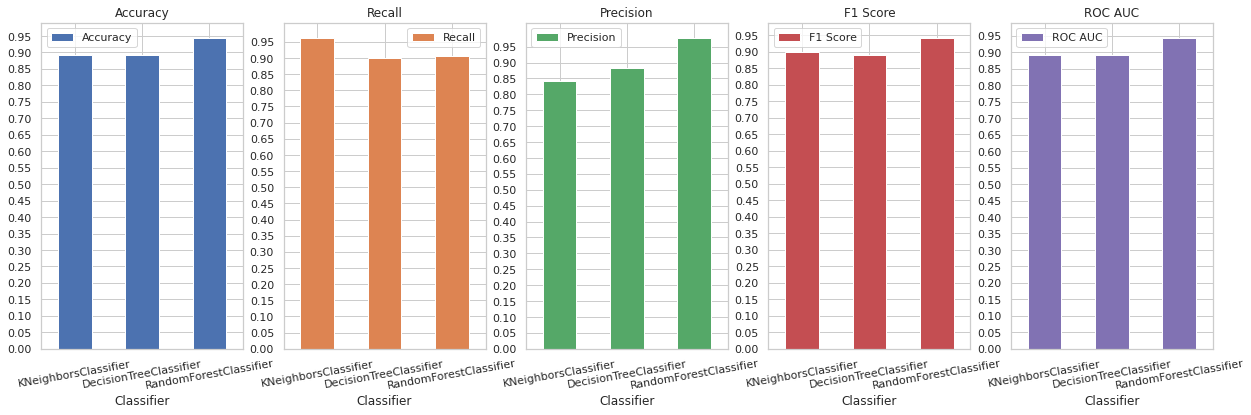

In [74]:
# Visual representation of evaluation metrics across all Classifier
models_balanced_evaluation_df.plot.bar(x='Classifier', subplots=True, figsize=(21, 6), layout=(1,5), rot=10,
                                       yticks=np.arange(0, 1, 0.05))

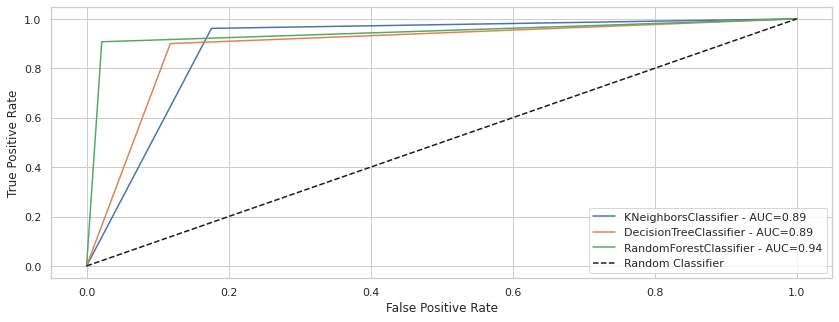

In [75]:
# Compare AUC score between Classifiers and compare to a Random Classifier
roc_results = get_roc_results(models_and_predictions)
plot_roc_curve(roc_results)

<font color='green'>Random Forest with a small False Positive Rate and high True Positive. KNN with an even higher True Positive Rate, but it's False Positive Rate is too high (low Precision) </font>

### <a class="anchor" id="3.4"></a><font color='green'>GridSearchCV - Hyperparameter Tuning to Improve RandomForestClassifier</font>

In [76]:
# Find the Random Forest model from all the models
model = None
y_pred = None

for model_, y_pred_ in models_and_predictions.items():
    if model_.__class__.__name__ == 'RandomForestClassifier':
        model = model_
        y_pred = y_pred_

# Check the number of features the model has seen during training
model.n_features_in_

19

In [77]:
print(sorted(list(zip(model.feature_names_in_, model.feature_importances_)), key=lambda x: x[-1], reverse=True))

[('loan_percent_income', 0.1996691317043735), ('person_income', 0.13814694195394575), ('loan_int_rate', 0.12518245253462176), ('loan_grade', 0.12061704808048973), ('loan_amnt', 0.07877628243183066), ('person_emp_length', 0.06398789700142885), ('cb_person_cred_hist_length', 0.056591879249108676), ('person_age', 0.05633195031236747), ('person_home_ownership_RENT', 0.03710232504618396), ('person_home_ownership_MORTGAGE', 0.02259726146128341), ('loan_intent_HOMEIMPROVEMENT', 0.015869300352671294), ('cb_person_default_on_file', 0.01557226450421035), ('person_home_ownership_OWN', 0.015371431021536203), ('loan_intent_MEDICAL', 0.01251733186124314), ('loan_intent_DEBTCONSOLIDATION', 0.01203712992323682), ('loan_intent_VENTURE', 0.011078484408383691), ('loan_intent_EDUCATION', 0.010018357647732477), ('loan_intent_PERSONAL', 0.008143919948497084), ('person_home_ownership_OTHER', 0.00038861055685525815)]


In [78]:
# Check the total number of features
len(X_train.columns)

19

<font color='green'>The total number of features used for training the RandomForestClassifier: **19**, which is all the available features in the training set</font>

In [79]:
# Check the number of features used for each DecisionTreeClassifier in the ensemble when looking for the best split
model.estimators_[0].max_features_

4

<font color='green'>This validates the fact that, the default value for the 'max_features' parameter for RandomForest is the sqrt of all features seen during fit, which in this case is 4</font>

<div class='alert alert-block alert-danger'> <u>Note:</u> The following block of code is computationally expensive. To save resources, some lines have been commented out. <strong>To use GridSearchCV for hyperparameter tuning for the RandomForestClassifier please remove the '#' from relevant lines!</strong></div>

In [80]:
# Create the hyperparameter grid for the max_features parameter
param_grid = {'max_features': np.arange(start=2, stop=len(X_train.columns))}

rf_model = RandomForestClassifier(n_estimators=500)
rf_model_cv = GridSearchCV(rf_model, param_grid, cv=3) # 'scoring' can be specified to use other than accuracy 
# rf_model_cv.fit(X_train, y_train)

# rf_model_cv.best_params_

<font color='green'>Using GridSearch Cross Validation to find the best 'max_features' value for the Random Forest to maximise the classification accuracy. The best value for the parameter in this case is 11. </font>

In [81]:
# rf_model_cv.score(X_test, y_test)

<font color='green'>Check for the new mean accuracy of the model using the parameter found by GridSearchCV. In this case the score is slightly better than by using 4 features for finding the best split</font>